In [1]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [3]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from torch.cuda import amp
from transformers import AutoModel, AutoTokenizer,AutoConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import torch
import warnings
from sklearn.model_selection import StratifiedKFold
import random
warnings.filterwarnings('ignore')
from collections import defaultdict
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
import gc
gc.enable()

In [4]:
splits = {'train': 'cleaned_train_binary.csv', 'val': 'cleaned_val_binary.csv','test':'cleaned_test_binary.csv'}
train_df = pd.read_csv("hf://datasets/kcrl/Shared_Task_Fake_News_binary/" + splits["train"])
val_df = pd.read_csv("hf://datasets/kcrl/Shared_Task_Fake_News_binary/" + splits["val"])
test_df = pd.read_csv("hf://datasets/kcrl/Shared_Task_Fake_News_binary/" + splits["test"])

In [5]:
with pd.option_context('display.max_colwidth',0):
    display(test_df.sample(n=5))

,text,label
119,ഇത് പണ്ടേ അറിയാവുന്ന കാര്യമാണ്. ചൈന എന്നും ലോകത്തിന് എതിരാണ്.ഉദാഹരണം ടിബറ്റ് ടിയാമൻ സ്ക്വയർ ഹോങ്കോങ് അറുനാചൽ പ്രദേശ് അങ്ങിനെ എത്രയോ.,Fake
809,തിരുവാതിര കളിക്ക് ഇടയിൽ ആരും ശ്രീകാന്ത് ജെട്ടിയാർ ജീയെ മറക്കല്ലേ,original
781,എന്തുകൊണ്ട് എന്ത്കൊണ്ട് എന്ത്കൊണ്ട്,Fake
645,thithithara. thy,original
29,ഈ പാട്ടുകേട്ടിരിക്കാൻ അപാര തൊലിക്കട്ടിതന്നെ വേണം,original


In [6]:
labeling = {
    'Fake': 0,
    'original': 1
}
val_df['label'] = val_df['label'].apply(lambda x : labeling[x])
test_df['label'] = test_df['label'].apply(lambda x : labeling[x])

In [7]:
test_df.head()

,text,label
0,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...,0
1,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...,0
2,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...,0
3,shame for entire woman&39;s of kerala,1
4,135 code janaghal andhu wide business cheythal...,0


In [8]:
class Config:
    NUM_EPOCHS = 15
    NUM_FOLDS = 10
    BATCH_SIZE = 32
    MODEL_PATH = "FacebookAI/xlm-roberta-base"
    LR = 2e-5
    DROPOUT = 0.3
    NUM_CLASSES = 2
    SEED = 42
    MAX_LEN = 130
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [9]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [10]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["text"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }

In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel,self).__init__()
        self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
        self.model = AutoModel.from_pretrained(config.MODEL_PATH,config = self.model_config)
        # Adjusting input size for three pooling methods
        self.dense = torch.nn.Linear(self.model_config.hidden_size * 3, self.model_config.hidden_size)
        self.dropout = torch.nn.Dropout(config.DROPOUT)
        self.classifier = nn.Linear(self.model_config.hidden_size, config.NUM_CLASSES)
        
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids,attention_mask=attention_mask)
        last_hidden_state = output[0]
        
        # CLS token
        cls_token = last_hidden_state[:,0,:]
        
        # Mean pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        
        # Max pooling
        last_hidden_state[input_mask_expanded == 0] = -1e9 
        max_embeddings = torch.max(last_hidden_state, 1)[0]
        
        # Concatenate all three embeddings
        pooled = torch.cat((cls_token, mean_embeddings, max_embeddings), 1)
        pooler = self.dense(pooled)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [13]:
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)
            # Get predictions
            pred = model(input_ids, attention_mask)
            
            # Apply argmax to get predicted class
            pred = torch.argmax(pred, dim=1)  # This will give us class predictions (0 or 1)
            
            predictions.append(pred.to("cpu").numpy())
    
    return np.concatenate(predictions)


In [14]:
test_df.shape

(1019, 2)

In [15]:
test_dataset = ClassifierDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, 
                        batch_size=64, 
                        drop_last=False,
                        collate_fn=data_collator, 
                        shuffle=False, 
                        num_workers=2)

total_samples = len(test_dataset)  
print(f"Initializing array for {total_samples} samples")

Initializing array for 1019 samples


In [16]:
all_predictions = np.zeros((config.NUM_FOLDS, total_samples))


for fold in range(config.NUM_FOLDS):            
    model_path = f"/kaggle/input/fake-news-cls-mean-max-fold/model_{fold}.bin"
    print(f"\nUsing {model_path}")
                        
    model = ClassifierModel()
    model.load_state_dict(torch.load(model_path))    
    model.to(config.DEVICE)
    
    # Get predictions for current fold
    fold_predictions = predict(model, test_loader)
    
    # Double check shapes before assignment
    print(f"all_predictions shape: {all_predictions.shape}")
    print(f"fold_predictions shape: {fold_predictions.shape}")
    
    assert len(fold_predictions) == total_samples, \
           f"Prediction length mismatch: got {len(fold_predictions)}, expected {total_samples}"
    
    # Store predictions for this fold
    all_predictions[fold] = fold_predictions
    
    # Free up memory
    del model
    gc.collect()

# Calculate mean predictions across all folds
final_predictions = all_predictions.mean(axis=0)


Using /kaggle/input/fake-news-cls-mean-max-fold/model_0.bin


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

all_predictions shape: (10, 1019)
fold_predictions shape: (1019,)

Using /kaggle/input/fake-news-cls-mean-max-fold/model_1.bin
all_predictions shape: (10, 1019)
fold_predictions shape: (1019,)

Using /kaggle/input/fake-news-cls-mean-max-fold/model_2.bin
all_predictions shape: (10, 1019)
fold_predictions shape: (1019,)

Using /kaggle/input/fake-news-cls-mean-max-fold/model_3.bin
all_predictions shape: (10, 1019)
fold_predictions shape: (1019,)

Using /kaggle/input/fake-news-cls-mean-max-fold/model_4.bin
all_predictions shape: (10, 1019)
fold_predictions shape: (1019,)

Using /kaggle/input/fake-news-cls-mean-max-fold/model_5.bin
all_predictions shape: (10, 1019)
fold_predictions shape: (1019,)

Using /kaggle/input/fake-news-cls-mean-max-fold/model_6.bin
all_predictions shape: (10, 1019)
fold_predictions shape: (1019,)

Using /kaggle/input/fake-news-cls-mean-max-fold/model_7.bin
all_predictions shape: (10, 1019)
fold_predictions shape: (1019,)

Using /kaggle/input/fake-news-cls-mean-max-f

In [23]:
binary_predictions = (final_predictions >= 0.310).astype(int)

In [22]:
# test_df['Labels'] = binary_predictions

In [23]:
# test_df.shape

(1019, 3)

In [24]:
y_true = test_df['label'].values
y_pred = binary_predictions

In [25]:
test_df.head()

,text,label
0,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...,0
1,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...,0
2,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...,0
3,shame for entire woman&39;s of kerala,1
4,135 code janaghal andhu wide business cheythal...,0


In [22]:
# labeling = {
#     0: 'Fake',
#     1: 'original'
# }
# test_df['Labels'] = test_df['Labels'].apply(lambda x : labeling[x])

In [23]:
# test_df.head()

,Id,text,Labels
0,Fake_01,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...,original
1,Fake_02,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...,Fake
2,Fake_03,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...,Fake
3,Fake_04,shame for entire woman&39;s of kerala,original
4,Fake_05,135 code janaghal andhu wide business cheythal...,original


In [24]:
# test_df.drop(columns =['text'], inplace = True)

In [25]:
# test_df.head()

,Id,Labels
0,Fake_01,original
1,Fake_02,Fake
2,Fake_03,Fake
3,Fake_04,original
4,Fake_05,original


In [26]:
# test_df.to_csv("KCRL_Malayalam_task1.csv", index = False)

In [27]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Print the classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Calculate individual metrics for weighted and macro averages
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_f1 = f1_score(y_true, y_pred, average='macro')

weighted_precision = precision_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')

weighted_recall = recall_score(y_true, y_pred, average='weighted')
macro_recall = recall_score(y_true, y_pred, average='macro')

accuracy = accuracy_score(y_true, y_pred)

# Print metrics
print("Macro F1 Score:", macro_f1)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       507
           1       0.84      0.92      0.88       512

    accuracy                           0.87      1019
   macro avg       0.88      0.87      0.87      1019
weighted avg       0.88      0.87      0.87      1019

Confusion Matrix:
 [[420  87]
 [ 41 471]]
Macro F1 Score: 0.8740712134085116
Macro Precision: 0.8775744641149441
Macro Recall: 0.8741621209319527
Accuracy: 0.8743866535819431


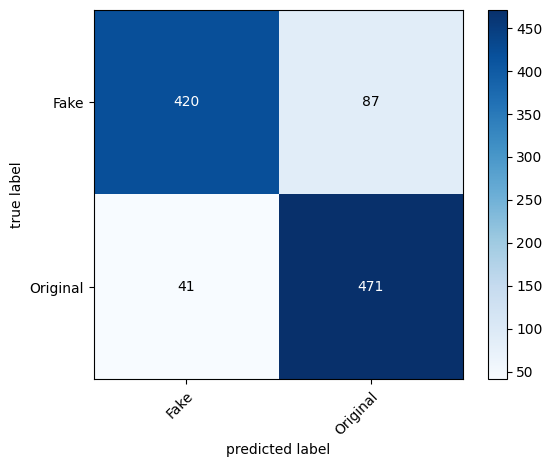

In [28]:
import torch
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
y_pred = torch.tensor(y_pred)
y_true = torch.tensor(y_true)

cmat = ConfusionMatrix(task="multiclass", num_classes=2)
confusion_matrix = cmat(y_pred, y_true)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
                                class_names=['Fake','Original'],
                                colorbar=True)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()

In [73]:
# y_true = val_df.label.values
# y_pred = binary_predictions

In [74]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# print(confusion_matrix(y_true, y_pred))

[[333  73]
 [ 30 379]]


In [25]:
# from sklearn.metrics import (
#     classification_report,
#     confusion_matrix,
#     f1_score,
#     accuracy_score,
#     precision_score,
#     recall_score
# )

# # Print the classification report
# print("Classification Report:\n", classification_report(y_true, y_pred))

# # Print the confusion matrix
# print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# # Calculate individual metrics for weighted and macro averages
# weighted_f1 = f1_score(y_true, y_pred, average='weighted')
# macro_f1 = f1_score(y_true, y_pred, average='macro')

# weighted_precision = precision_score(y_true, y_pred, average='weighted')
# macro_precision = precision_score(y_true, y_pred, average='macro')

# weighted_recall = recall_score(y_true, y_pred, average='weighted')
# macro_recall = recall_score(y_true, y_pred, average='macro')

# accuracy = accuracy_score(y_true, y_pred)

# # Print metrics
# print("Weighted F1 Score:", weighted_f1)
# print("Macro F1 Score:", macro_f1)
# print("Weighted Precision:", weighted_precision)
# print("Macro Precision:", macro_precision)
# print("Weighted Recall:", weighted_recall)
# print("Macro Recall:", macro_recall)
# print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       507
           1       0.84      0.92      0.88       512

    accuracy                           0.87      1019
   macro avg       0.88      0.87      0.87      1019
weighted avg       0.88      0.87      0.87      1019

Confusion Matrix:
 [[420  87]
 [ 41 471]]
Weighted F1 Score: 0.8741021389157108
Macro F1 Score: 0.8740712134085116
Weighted Precision: 0.877410143984377
Macro Precision: 0.8775744641149441
Weighted Recall: 0.8743866535819431
Macro Recall: 0.8741621209319527
Accuracy: 0.8743866535819431


In [22]:
# import torch
# import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_confusion_matrix
# from torchmetrics import ConfusionMatrix
# y_pred = torch.tensor(y_pred)
# y_true = torch.tensor(y_true)

# cmat = ConfusionMatrix(task="multiclass", num_classes=2)
# confusion_matrix = cmat(y_pred, y_true)

# fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
#                                 class_names=['Fake','Original'],
#                                 colorbar=True)

# # Rotate the x-axis labels
# plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# # Show the plot
# plt.show()

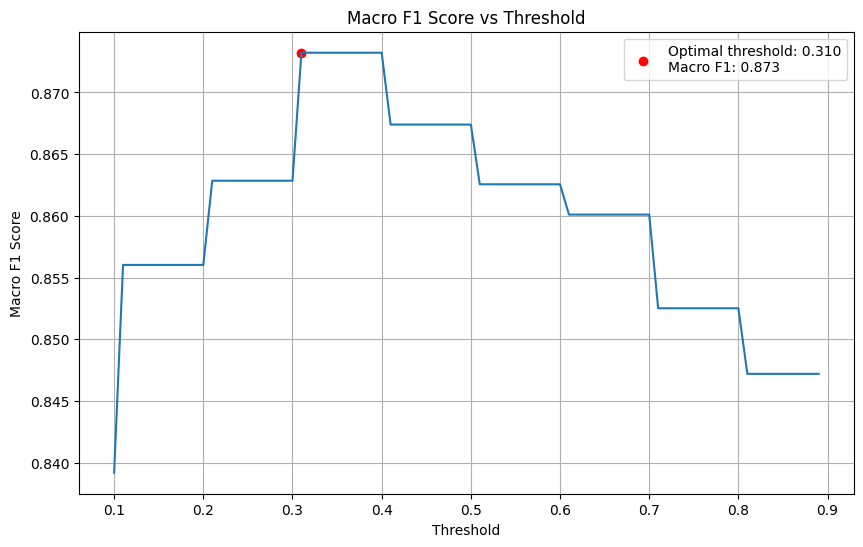


Macro F1 scores around optimal threshold:
Threshold  |  Macro F1 
-------------------------
  0.270    |   0.863   
  0.280    |   0.863   
  0.290    |   0.863   
  0.300    |   0.863   
  0.310    |   0.873   
  0.320    |   0.873   
  0.330    |   0.873   
  0.340    |   0.873   
  0.350    |   0.873   
  0.360    |   0.873   

Final Macro F1 score with optimal threshold: 0.8732


In [71]:
# from sklearn.metrics import f1_score
# import numpy as np
# import matplotlib.pyplot as plt

# def find_optimal_threshold_macro_f1(y_true, y_pred_proba, plot=True):
#     """
#     Find optimal threshold that maximizes macro F1-score
#     Args:
#         y_true: Ground truth labels
#         y_pred_proba: Model predictions (probabilities/mean of fold predictions)
#         plot: Whether to plot F1 scores for different thresholds
#     Returns:
#         optimal_threshold: Threshold that gives best macro F1-score
#     """
#     # Try thresholds from 0.1 to 0.9 with small steps
#     thresholds = np.arange(0.1, 0.9, 0.01)
#     f1_scores = []
    
#     # Calculate macro F1 score for each threshold
#     for threshold in thresholds:
#         y_pred = (y_pred_proba >= threshold).astype(int)
#         macro_f1 = f1_score(y_true, y_pred, average='macro')
#         f1_scores.append(macro_f1)
    
#     # Find the optimal threshold
#     optimal_idx = np.argmax(f1_scores)
#     optimal_threshold = thresholds[optimal_idx]
#     best_f1 = f1_scores[optimal_idx]
    
#     if plot:
#         plt.figure(figsize=(10, 6))
#         plt.plot(thresholds, f1_scores)
#         plt.scatter(optimal_threshold, best_f1, color='red', 
#                    label=f'Optimal threshold: {optimal_threshold:.3f}\nMacro F1: {best_f1:.3f}')
#         plt.xlabel('Threshold')
#         plt.ylabel('Macro F1 Score')
#         plt.title('Macro F1 Score vs Threshold')
#         plt.grid(True)
#         plt.legend()
#         plt.show()
    
#     # Print results for different thresholds around the optimal one
#     print("\nMacro F1 scores around optimal threshold:")
#     print(f"{'Threshold':^10} | {'Macro F1':^10}")
#     print("-" * 25)
#     window = 0.05  # Show thresholds ±0.05 around optimal
#     for threshold in thresholds:
#         if abs(threshold - optimal_threshold) <= window:
#             y_pred = (y_pred_proba >= threshold).astype(int)
#             macro_f1 = f1_score(y_true, y_pred, average='macro')
#             print(f"{threshold:^10.3f} | {macro_f1:^10.3f}")
    
#     return optimal_threshold

# # Use the function with your predictions
# optimal_threshold = find_optimal_threshold_macro_f1(val_df['label'].values, final_predictions)

# # Apply the optimal threshold
# binary_predictions = (final_predictions >= optimal_threshold).astype(int)

# # Print final macro F1 score
# final_macro_f1 = f1_score(val_df['label'].values, binary_predictions, average='macro')
# print(f"\nFinal Macro F1 score with optimal threshold: {final_macro_f1:.4f}")